In [1]:
import numpy as np
import torch
from torch import nn  
import time 
import os  
import xarray as xr
import subprocess
import matplotlib.pyplot as plt
from matplotlib import colors
import cartopy.crs as ccrs

In [2]:
## import self defined functions
from sys import path 
# insert at 1, 0 is the script path (or '' in REPL)
path.insert(1, '/tigress/cw55/local/python_lib')
from cg_funcs import global_mean_xarray
root = '/tigress/cw55/work/2022_radi_nn/NN_AM4'
path.insert(1,  root)
path.insert(1,  root+'/work')
# import work.lw_csaf_Li5Relu_EN.train_script01 as lwcsafen
import lw_csaf_Li5Relu_EY.train_script01 as lwcsafey 
# import work.lw_af_Li5Relu_EN.train_script01 as lwafen
import lw_af_Li5Relu_EY.train_script01 as lwafey 

In [3]:
from get_AM4_data_lw import get_AM4_data_lw
######################################################
# common functions to split the training and test data
from NNRTMC_lw_utils import  split_train_test_sample, \
draw_batches, data_std_normalization, print_key_results, return_exp_dir
    
from diag_utils import batch_index_sta_end, pred_NN_batch,\
create_6tiles_lw,regrid_6tile2latlon

In [4]:
plt.rcParams['font.size'] = '6'

In [5]:
file_path = '/scratch/gpfs/cw55/AM4/work/CTL1990s_test_NN_1ytime_stellarcpu_intelmpi_22_768PE/POSTP/'
ds = xr.open_dataset(file_path+'19900101.atmos_8xdaily.nc')
# ds = xr.open_dataset(file_path+'19910101.atmos_8xdaily.nc')
# ds = xr.open_dataset(file_path+'19920101.atmos_8xdaily.nc')
# ds = xr.open_dataset(file_path+'19930101.atmos_8xdaily.nc')
ds = ds.rename({'grid_yt':'lat','grid_xt':'lon'})

In [41]:
def plot_var12_diff(var1,level = np.arange(0,300,10), dlevel = np.arange(-10,10,0.5)):
    fig, axs = plt.subplots(nrows=1,ncols=3,figsize=(8,2),dpi=200)
    axs = axs.flatten()
    for i in range(2):
        ax=axs[i]
        da = ds[var1[i]].mean('time')
        da.plot(ax=ax, levels=level, extend='both') 
        ax.set_title(f'{var1[i]} GM: {global_mean_xarray(da).values:4.2f}')  
    ax=axs[2]
    da = (ds[var1[0]].mean('time')-ds[var1[1]].mean('time'))
    da.plot(ax=ax, levels=dlevel, extend='both') 
    ax.set_title(f'diff GM: {global_mean_xarray(da).values:4.2f}')  
    for ax in axs:
        ax.set(xlabel=None,ylabel=None)
    fig.tight_layout()  

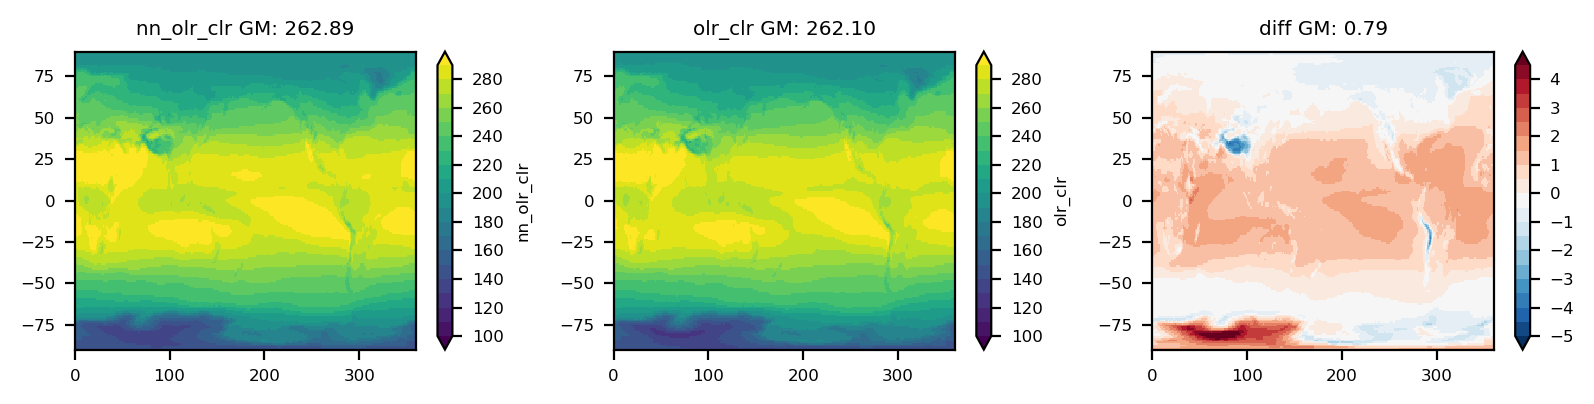

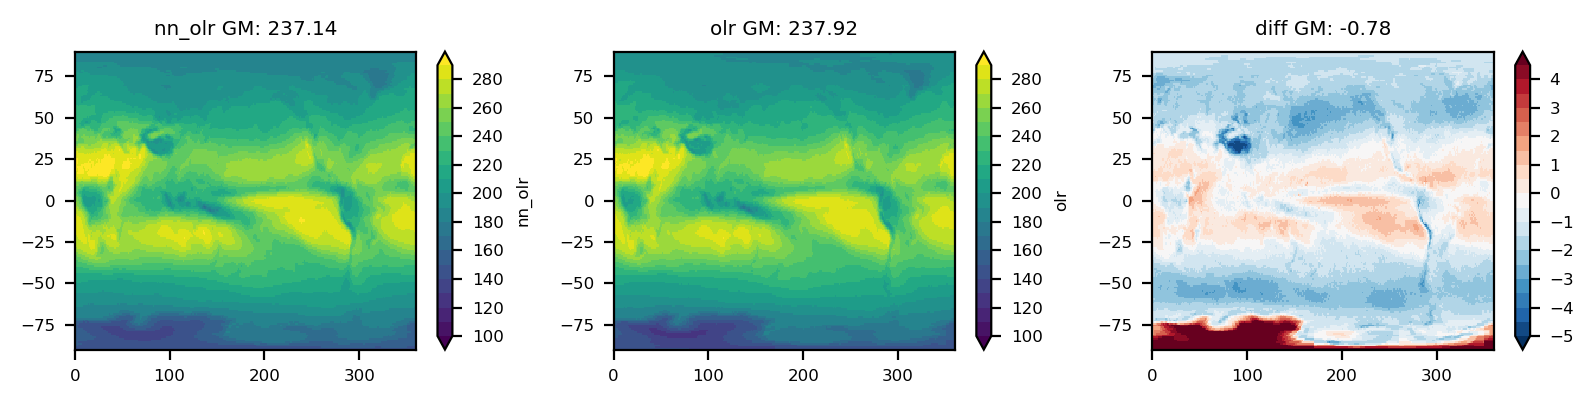

In [42]:
var = ['nn_olr_clr','olr_clr',]
plot_var12_diff(var,level = np.arange(100,300,10), dlevel = np.arange(-5,5,0.5))

var = ['nn_olr','olr',]
plot_var12_diff(var,level = np.arange(100,300,10), dlevel = np.arange(-5,5,0.5))

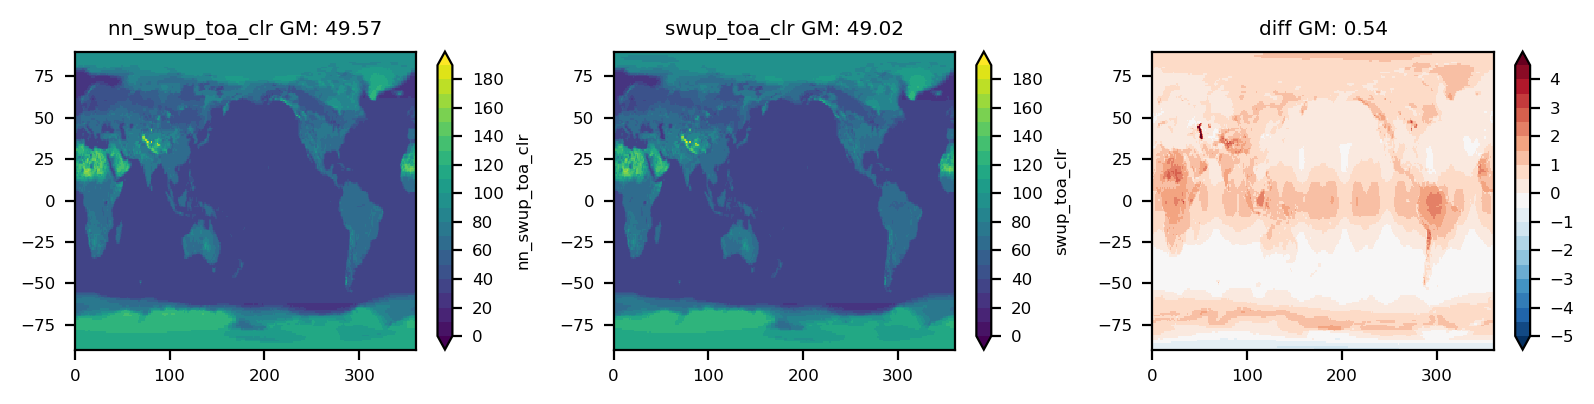

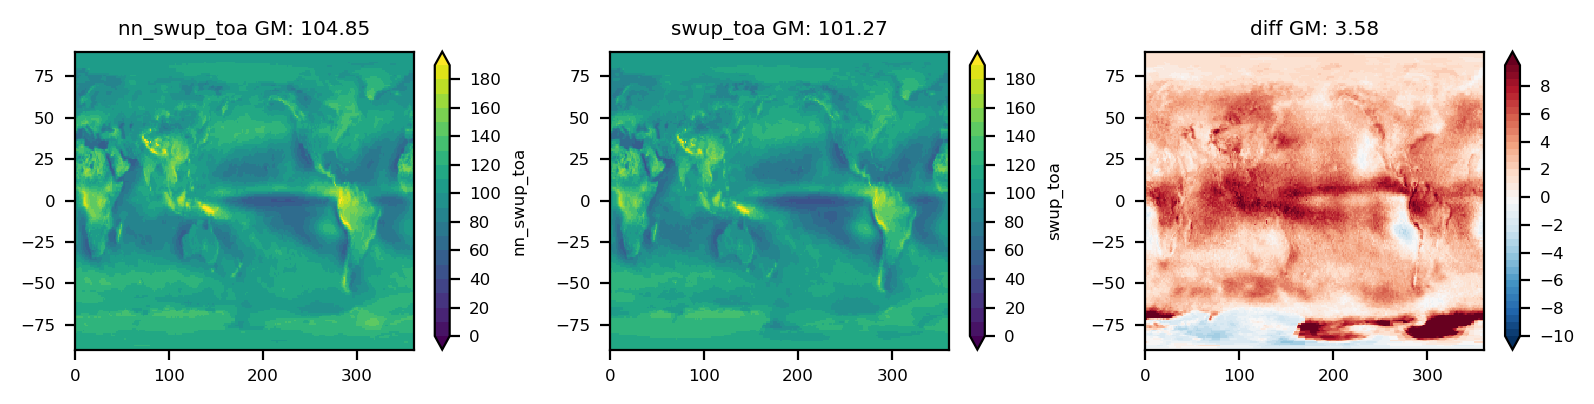

In [43]:
var = ['nn_swup_toa_clr','swup_toa_clr',]
plot_var12_diff(var,level = np.arange(0,200,10), dlevel = np.arange(-5,5,0.5))
var = ['nn_swup_toa','swup_toa',]
plot_var12_diff(var,level = np.arange(0,200,10), dlevel = np.arange(-10,10,0.5))

In [9]:
def plot_var12_diff2(var1,ds_sel,level1=np.arange(-500,1400,100),level2=np.arange(-500,500,100)):
    fig, axs = plt.subplots(nrows=1,ncols=3,figsize=(8,2),dpi=200)
    axs = axs.flatten() 
    for i in range(3): 
        ax=axs[i] 
        da = ds_sel[var1[0]]
        da.plot.contour(ax=ax, levels=np.arange(-500,1400,500)) 
    for i in range(2):
        ax=axs[i]
        da = ds_sel[var1[i]]
        da.plot(ax=ax, levels=level1, extend='both') 
        ax.set_title(f'{var1[i]} GM: {global_mean_xarray(da).values:4.2f}')  
    ax=axs[2]
    level = level2
    da = (ds_sel[var1[1]]-ds_sel[var1[0]])
    da.plot(ax=ax, levels=level2, extend='both') 
    ax.set_title(f'diff GM: {global_mean_xarray(da).values:4.2f}') 
    for ax in axs:
        ax.set(xlabel=None,ylabel=None)
    fig.tight_layout()  

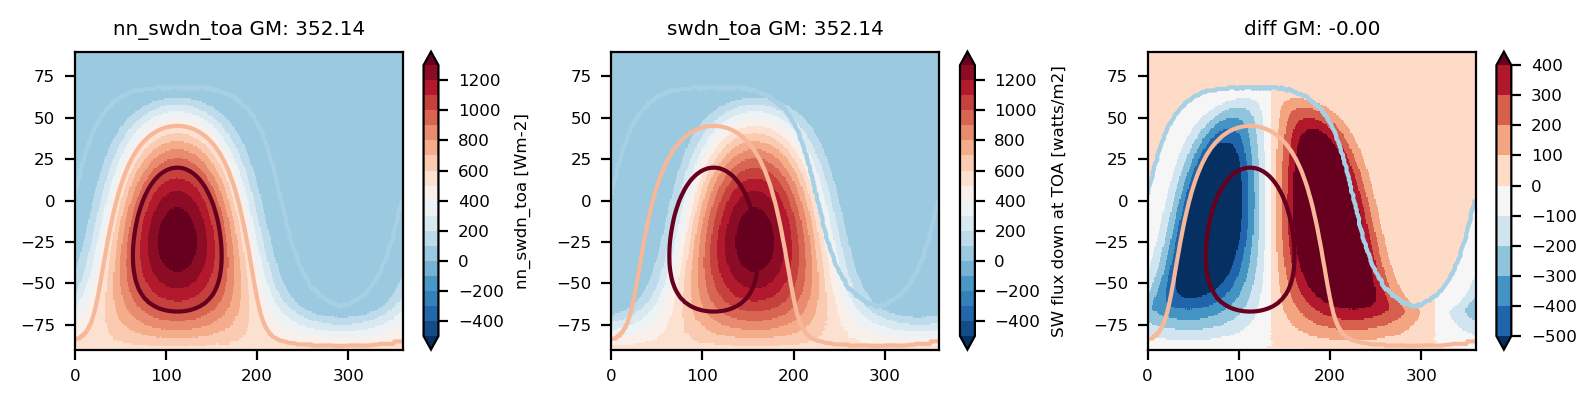

In [10]:
var = ['nn_swdn_toa','swdn_toa',]
# ds_sel = ds.mean('time')
ds_sel = ds.isel(time=0)
plot_var12_diff2(var,ds_sel)

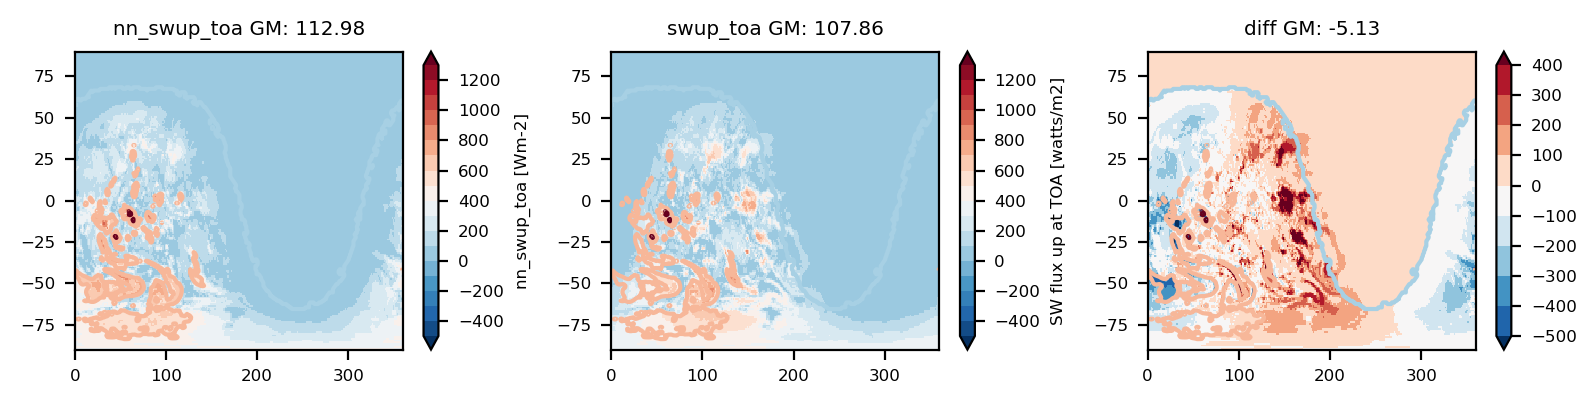

In [11]:
var = ['nn_swup_toa','swup_toa',]
# ds_sel = ds.mean('time')
ds_sel = ds.isel(time=1)
plot_var12_diff2(var,ds_sel)

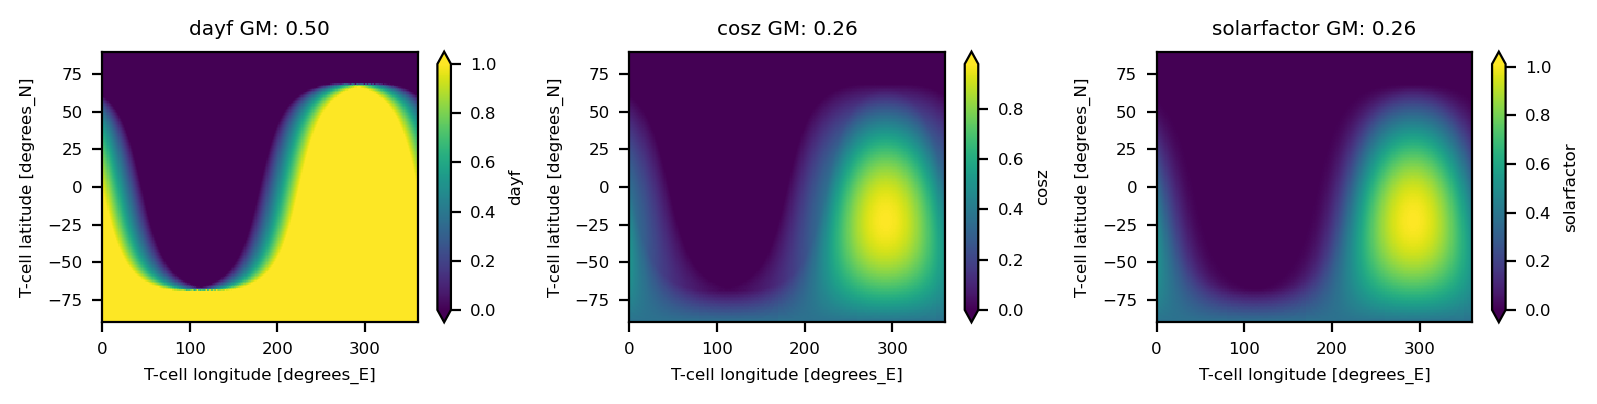

In [14]:

ds_sel = ds.isel(time=100)

var1 = [ds_sel['dayf'],ds_sel['cosz'],ds_sel['solarfactor']]

fig, axs = plt.subplots(nrows=1,ncols=3,figsize=(8,2),dpi=200)
axs = axs.flatten()
# level = np.arange(0,1400,10)
for i in range(3):
    ax=axs[i]
    da = var1[i]
    da.plot(ax=ax, extend='both') 
    ax.set_title(f'{var1[i].long_name} GM: {global_mean_xarray(da).values:4.2f}')   
fig.tight_layout()  
fig.show()